# Улучшение технологического процесса восстановления золота из руды

## 1. Описание проекта

### 1.2. Цель

Подготовить прототип модели машинного обучения для компании, которая разрабатывает решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды с использованием данных с параметрами добычи и очистки руды. Модель должна помочь оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### 1.2. План работы

1. Подготовить данные.
   - Ознакомиться с данными.
   - Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery и найти MAE между расчётами и значением признака.
   - Проанализировать признаки, недоступные в тестовой выборке. 
   - Выполнить предобработку данных.
2. Проанализировать данные.
   - Изучить, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. 
   - Сравнить распределения размеров гранул исходного сырья на обучающей и тестовой выборках. 
   - Исследовать суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.
3. Построить модель машинного обучения.
   - Написать функцию для вычисления итоговой метрики качества*.
   - Обучить разные модели и оцените их качество кросс-валидацией. 
   - Выбрать лучшую модель и проверить её на тестовой выборке. 


### 1.3. Описание данных

Данные находятся в трёх файлах:
- gold_recovery_train_new.csv — обучающая выборка;
- gold_recovery_test_new.csv — тестовая выборка;
- gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

Данные представлены "сырые", то есть без какой-либо обработки: их просто выгрузили из хранилища. 

*Технологический процесс:*
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  - Xanthate — ксантогенат (промотер, или активатор флотации);
  - Sulphate — сульфат (на данном производстве сульфид натрия);
  - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

*Параметры этапов:*
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

*Целевые признаки:*
- rougher.output.recovery - эффективность обогащения чернового концентрата;
- final.output.recovery - эффективность обогащения финального концентрата.

\* Итоговая метрика SMAPE вычисляется по следующей формуле: Итоговое SMAPE = 25% * SMAPE(*rougher.output.recovery*) * 75% * SMAPE(*final.output.recovery*).

## 2. Подготовка данных

### 2.1. Знакомство с данными

Импортируем необходимые библиотеки и считаем данные из файлов.

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

RANDOM_STATE = 0

In [133]:
train = pd.read_csv('gold_recovery_train_new.csv')
test = pd.read_csv('gold_recovery_test_new.csv')
full = pd.read_csv('gold_recovery_full_new.csv')

In [134]:
# Задаём условие, что при использовании функции display() для вывода датафрейма на экран
# будут показываться все его столбцы и строки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Изучим основную информацию о датафреймах. Для этого выведем первые 5 строк датафреймов, вызовем для них метод `info`, посмотрим количество пропусков в столбцах и проверим наличие мультиколлинеарности между признаками датафрейма.

In [135]:
# Функция для визуализации объёма пропусков в датафрейме
def pass_value_barh(df):
    if df.isna().sum().sum() > 0:
        ax = (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(12,15), legend=False, fontsize=12)
        )
        ax.set_title('Объём пропусков в данных \n', fontsize=18, color='SteelBlue')
        ax.set_ylabel('Названия столбцов', fontsize=14)
        ax.set_xlabel('% пропусков', fontsize=14)
    else:
        print('В датафрейме нет пропусков.')

In [136]:
# Функция для получения основной информации о датафрейме
def get_info(data):
    print('Первые 5 строк датафрейма:')
    display(data.head(5))
    
    data.info()
    print()
    
    print('Количество дубликатов в столбце date:', data.duplicated(['date']).sum())
    
    print('Количество сильно коррелирующих признаков (мультиколлинеарность):',
      ((data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1, errors = 'ignore').corr() > 0.8).sum() - 1) \
      [((data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1, errors = 'ignore').corr() > 0.8) \
        .sum() - 1) > 0].count()
     )
    
    pass_value_barh(full)

Первые 5 строк датафрейма:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


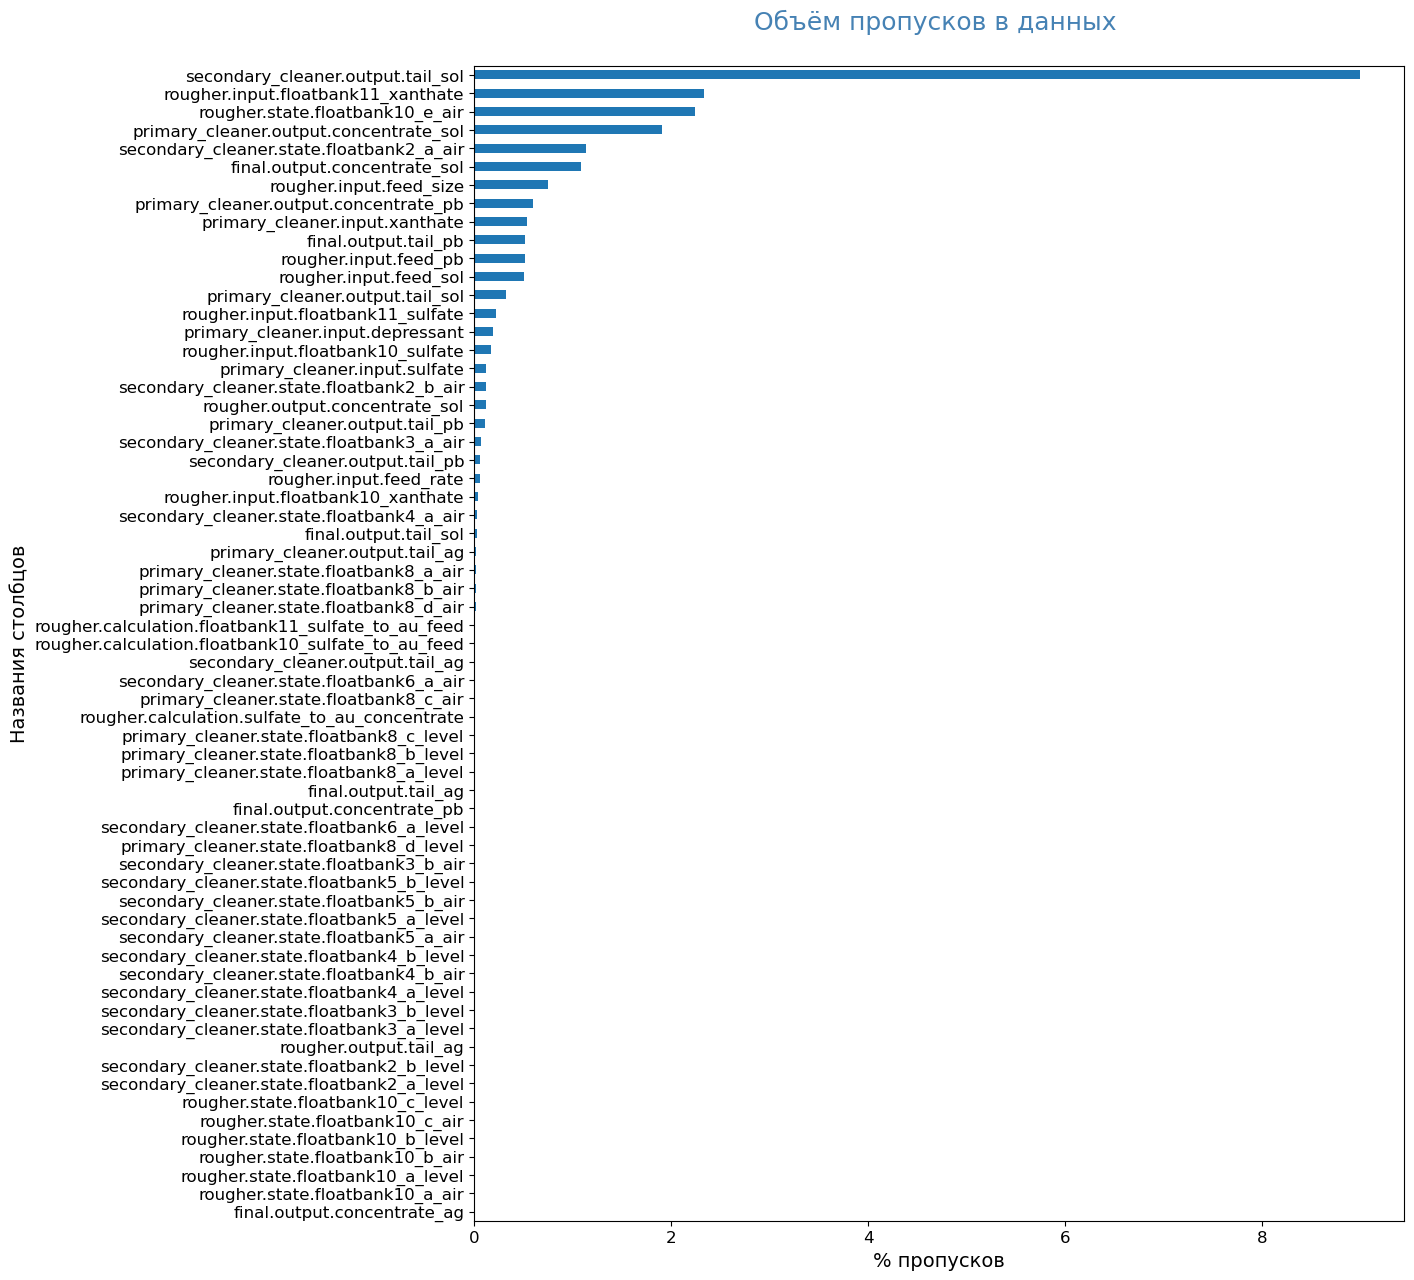

In [137]:
get_info(full)

Первые 5 строк датафрейма:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


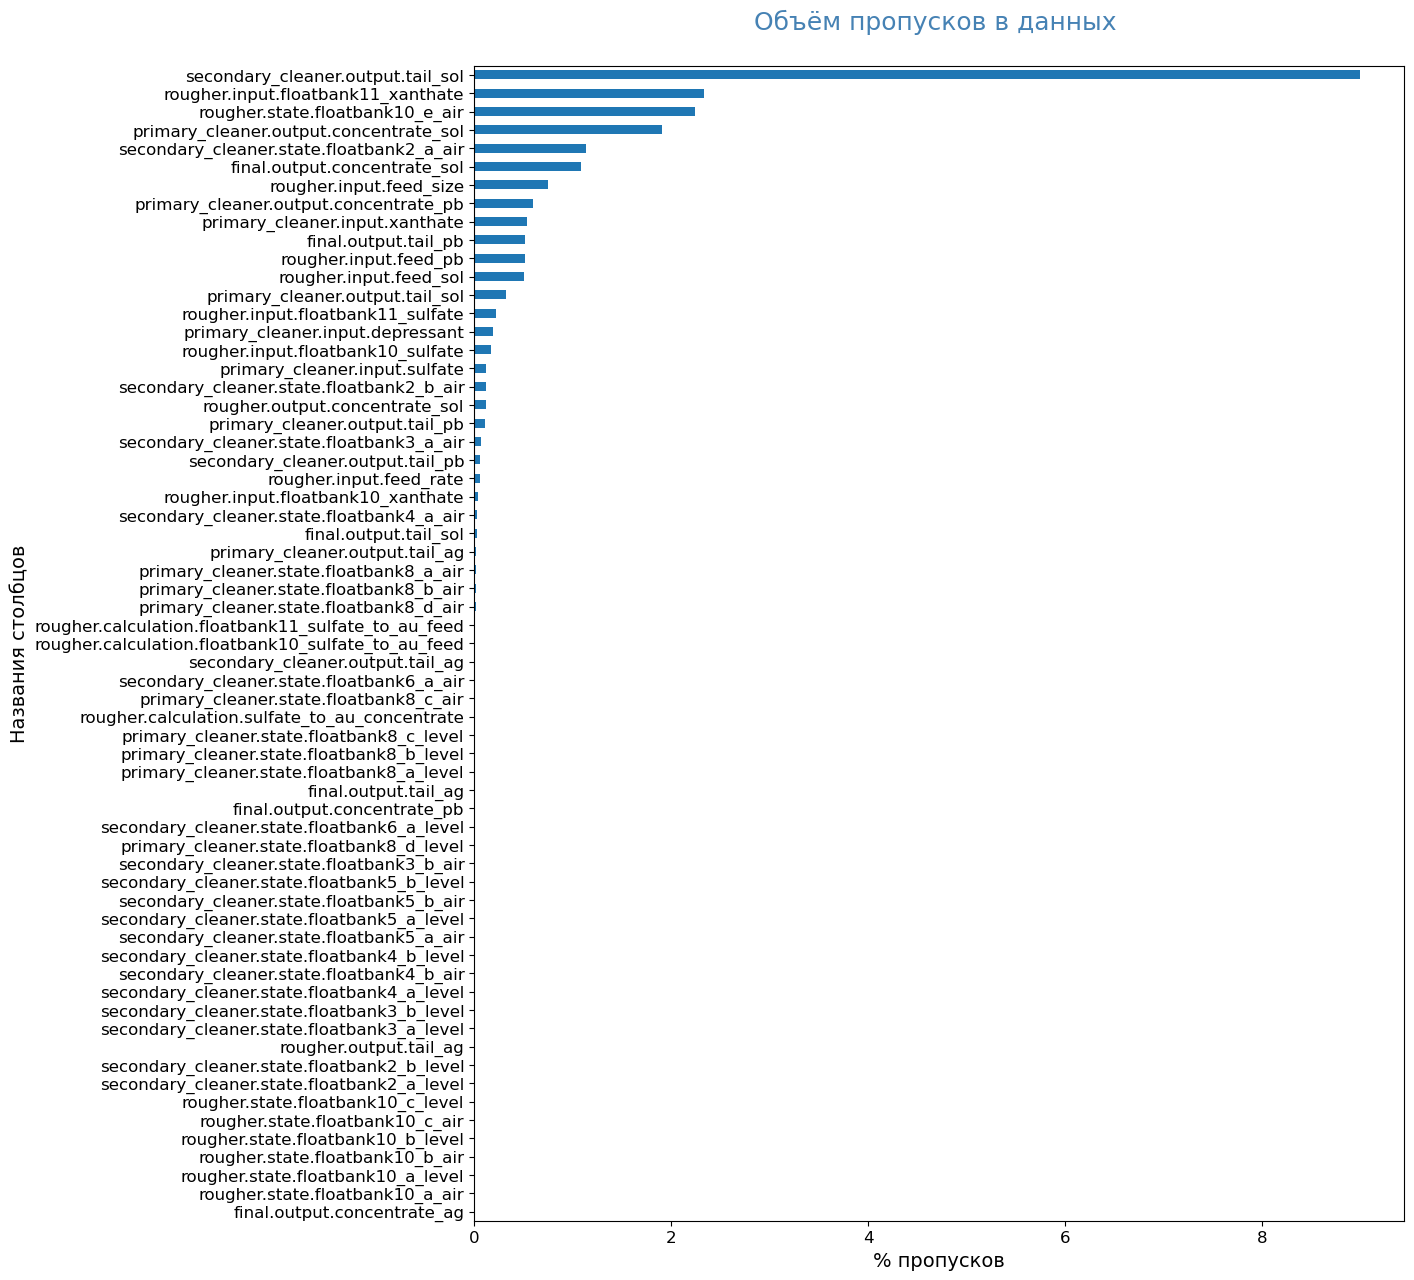

In [138]:
get_info(train)

Первые 5 строк датафрейма:


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

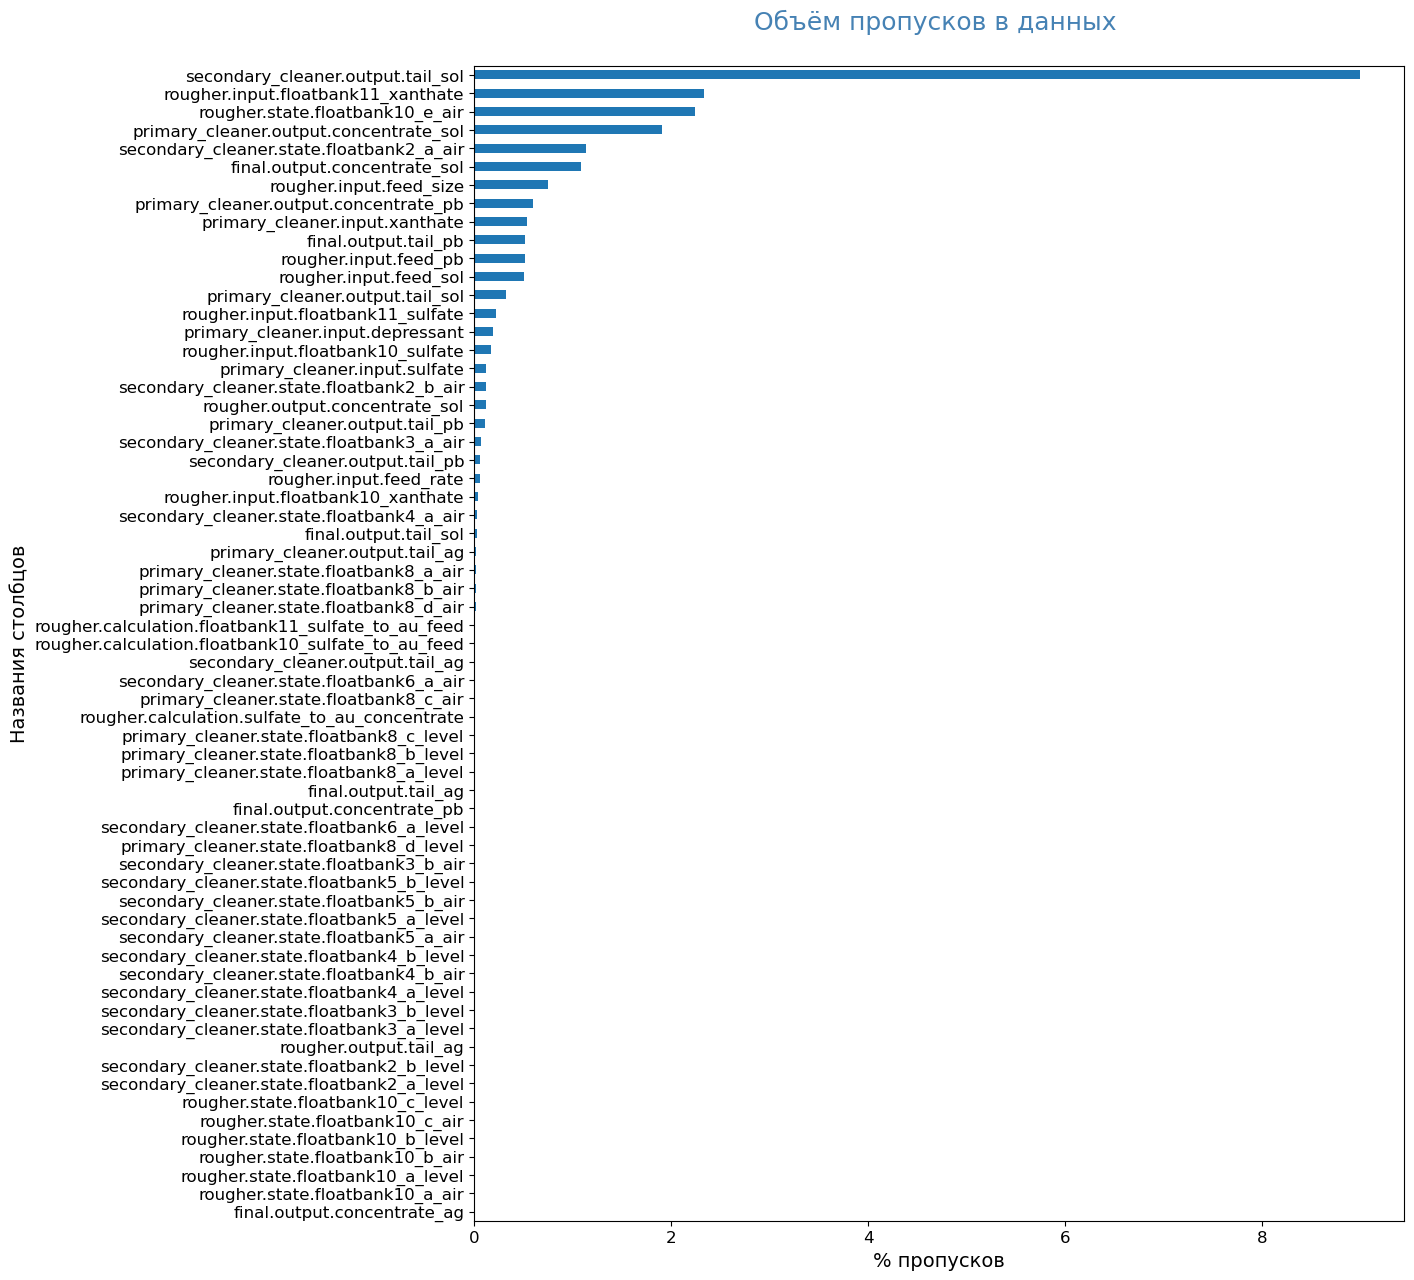

In [139]:
get_info(test)

**Выводы после изучения данных.**
- Датафрейм `train` содержит примерно 73% данных из `full`, а `test` - около 27% соответственно. При этом часть столбцов при формировании `test` из `full` была опущена, а именно 34 столбца, в которых, по условию, содержатся значения параметров, которые замеряются и/или рассчитываются значительно позже получения основной информации о характеристиках руды на разных этапах её обработки.
- Видим, что все признаки, кроме `date`, имеют числовой тип данных, а `date` - тип данных `object`. Далее приведём этот столбец во всех датафреймах к типу данных `datetime`, чтобы с данными в этом столбце было удобно работать как со значениями даты и времени.
- Пропуски есть больше, чем в половине столбцов каждого датафрейма; в данном случае мы можем их заполнить по следующей причине. Данные о характеристиках руды на каждом этапе фиксируются каждый час, и в датафреймах строки расположены последовательно с учётом даты и времени получения информации, соответственно значения в соседних ячейках зависят друг от друга, поскольку параметры руды изменяются не случайным образом, а в последовательно и постепенно.
- Дубликатов в датафрейме нет. Их поиск осуществлялся только по столбцу `date`, поскольку теоретически может быть такое, что характеристики руды будут повторяться (хотя вероятность этого очень мала, поскольку этих характеристик больше 80), однако, записей сделанных в одно время быть не должно: это может быть, например, свидетельством какого-то сбоя в системе, поскольку записи делаются с заданным временным интервалом.
- Гистограммы мы не строили, поскольку столбцов очень много, и все графики бы смешались. Однако по первым строкам датафрейма можно сказать, что признаки лежат в разных диапазонах; также можно предположить, что их распределений имеют разный вид. Всё это значит, что при использовании линейной модели будет предпочтительнее выполнить нормализацию данных.
- Больше 30 признаков сильно коррелируют с другими признаками, то есть имеет место мультиколлинеарность, что может отрицательно сказаться на качестве предсказаний линейной модели. В данном случае мы не можем ничего с этим сделать, поскольку, во-первых, признаки в датафреймах отражают последовательные этапы обогащения руды, где выход одного этапа - вход другого, во-вторых, многие признаки сильно коррелируют более, чем с одним другим признаком, а их более 80, поэтому в мы не можем удалить какой-то признак, не нарушив, целостности данных и взаимосвязи признаков.

### 2.2. Проверка правильности расчёта эффективность обогащения руды

Проверим, что эффективность обогащения руды рассчитана правильно: вычислим её на обучающей выборке для признака `rougher.output.recovery` и найдём MAE между расчётами и значением признака в датафрейме.

In [140]:
# Эффективность обогащение руды на этапе флатации, вычисленная по соответствующей формуле
calc_recovery = (
    train['rougher.output.concentrate_au'] * (train['rougher.input.feed_au'] - train['rougher.output.tail_au']) /
    (train['rougher.input.feed_au'] * (train['rougher.output.concentrate_au'] - train['rougher.output.tail_au']))
    * 100
)

In [141]:
print('MAE:', mean_absolute_error(train['rougher.output.recovery'], calc_recovery))

MAE: 9.73512347450521e-15


Значение МАЕ очень маленькое, можно считать его равным нулю. Это означает, что теоретические (рассчитанные по формуле) значения эффективность обогащения руды на этапе флотации практически полностью равны значениям, измеренным во время обработки руды на предприятии, то есть последние рассчитаны правильно.

### 2.3. Анализ признаков, недоступных в тестовой выборке

Посмотрим, какие столбцы у нас не попали в тестовую выборку, но которые есть в обучающей.

In [142]:
col_for_del = set(train.columns) - set(test.columns)
col_for_del

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Видим, что в признаках `test` отсутствуют следующие параметры:
- все параметры, которые получают на выходе каждого из этапа обогащения руды ([этап].output.[название_параметра]), а это "хвосты", то есть остатки продукта с низкой концентрацией ценных металлов, концентрации различных веществ и два целевых признака.
- несколько расчётных характеристик этапа флотации (rougher.calculation.[название_параметра]). 

По условию в тестовой выборке отсутствуют параметры, которые рассчитываются или измеряются значительно позже остальных, именно это мы и видим. Параметры, характеризующие состояние сырья перед каждым этапом и состояние самого этапа обработки, в тестовую выборку попали, а вот параметры продуктов, получаемых на выходе каждого из этапов, и расчётные характеристики этапа флотации в ней отсутствуют. Это логично, поскольку то, что получается на выходе каждого этапа и то, что получается в результате расчётов, зависит от того, что подали на вход и от параметров, характеризующих этапы обработки руды.

Так как мы будем проверять работу модели на выборке `test`, то в обучающей выборке `train` должны быть те же признаки, что и в тестовой, иначе при тестировании появится ошибка. Соответственно, из выборки `train` на этапе предобработки данных мы удалим все признаки, которых нет в `test`, кроме двух целевых: их наоборот нужно будет добавить в тестовую выборку из исходного датафрейма.

### 2.4. Предобработка данных

В предобработку данных войдёт:
- удаление признака `date` из датафреймов `train` и `test`, поскольку эффективность обогащения руды (целевые признаки) не зависит от времени измерения характеристик руды и параметров процессов флотации и очистки;
- приведение столбца `date` к типу данных `datetime` в датафрейме `full`; этот признак из исходного датафрейма не удаляем на случай, если он понадобится для анализа;
- заполнение пропусков в датафреймах `train` и `test`, в `full` заполнять пропуски не будем, чтобы не искажать исходные данные, если они понадобятся для анализа;
- добавление в `test` двух целевых признаков из датафрейма `full`: `rougher.output.recovery` и `final.output.recovery`;
- удаление тех признаков из обучающей выборки, которых нет в тестовой, кроме целевых переменных.

Пропуски в датафрейме будем заполнять с помощью метода `pd.DataFrame.interpolate` с параметром `method='linear'`.Его преимущество в том, что он заполняет пропуски с использованием метода линейной интерполяции, что поможет добиться более точного результата. Однако его недостаток в том, что пропуски в первой строке датафрейма он не заполняет, поскольку нет предыдущей записи для интерполяции. С пропусками в последних строках такой проблемы нет: значения в них заполняются последним не NaN-значением в столбце.

Нормализацию данных при необходимости будем проводить на этапе подбора модели, подходящей для решения поставленной задачи.

In [143]:
# В список столбцов для удаления из обучающей выборки добавляем признак date, и удаляем из него целевые признаки
col_for_del = list(col_for_del - set(['rougher.output.recovery', 'final.output.recovery']) | set(['date']))

# Добавляем в тестовую выборку целевые признаки
# Вместе с ними добавляются и остальные отсутствующие в тестовой выборке столбцы, поэтому далее их нужно будет оттуда удалить
test = test.merge(full, how='inner', on=list(test.columns))

test.drop(col_for_del, axis=1, inplace=True)
train.drop(col_for_del, axis=1, inplace=True)

full['date'] = pd.to_datetime(full['date'], format='%Y-%m-%d %H:%M:%S')

In [144]:
# Функция для заполнения пропусков в датафрейме
def fill_nan(df):
    col_for_interpolate = []
    if 'date' in df.columns:
        col_for_interpolate = df.columns.to_list()
        col_for_interpolate.remove('date')
    else:
        col_for_interpolate = df.columns
    df[col_for_interpolate] = df[col_for_interpolate].interpolate(method='linear')
    
    # Если в первой строке остались пропуски, то заполняем следующими значениями в столбце
    if df.loc[0, :].isna().sum() != 0:
        df.loc[0:1, :] = df.loc[0:1, :].fillna(method='bfill', axis=0)

In [145]:
fill_nan(train)
fill_nan(test)

Проверим, что все изменения были выполнены.

In [146]:
print('Количество столбцов, которые есть в обучающей выборке и нет в тестовой:', len(set(train.columns) - set(test.columns)))
print(f'Число пропусков в обучающей выборке - {train.isna().sum().sum()}; в тестовой выборке - {test.isna().sum().sum()}.')

Количество столбцов, которые есть в обучающей выборке и нет в тестовой: 0
Число пропусков в обучающей выборке - 0; в тестовой выборке - 0.


## 3. Анализ данных

### 3.1. Анализ концентрации металлов в руде

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах обработки золотосодержащей руды.

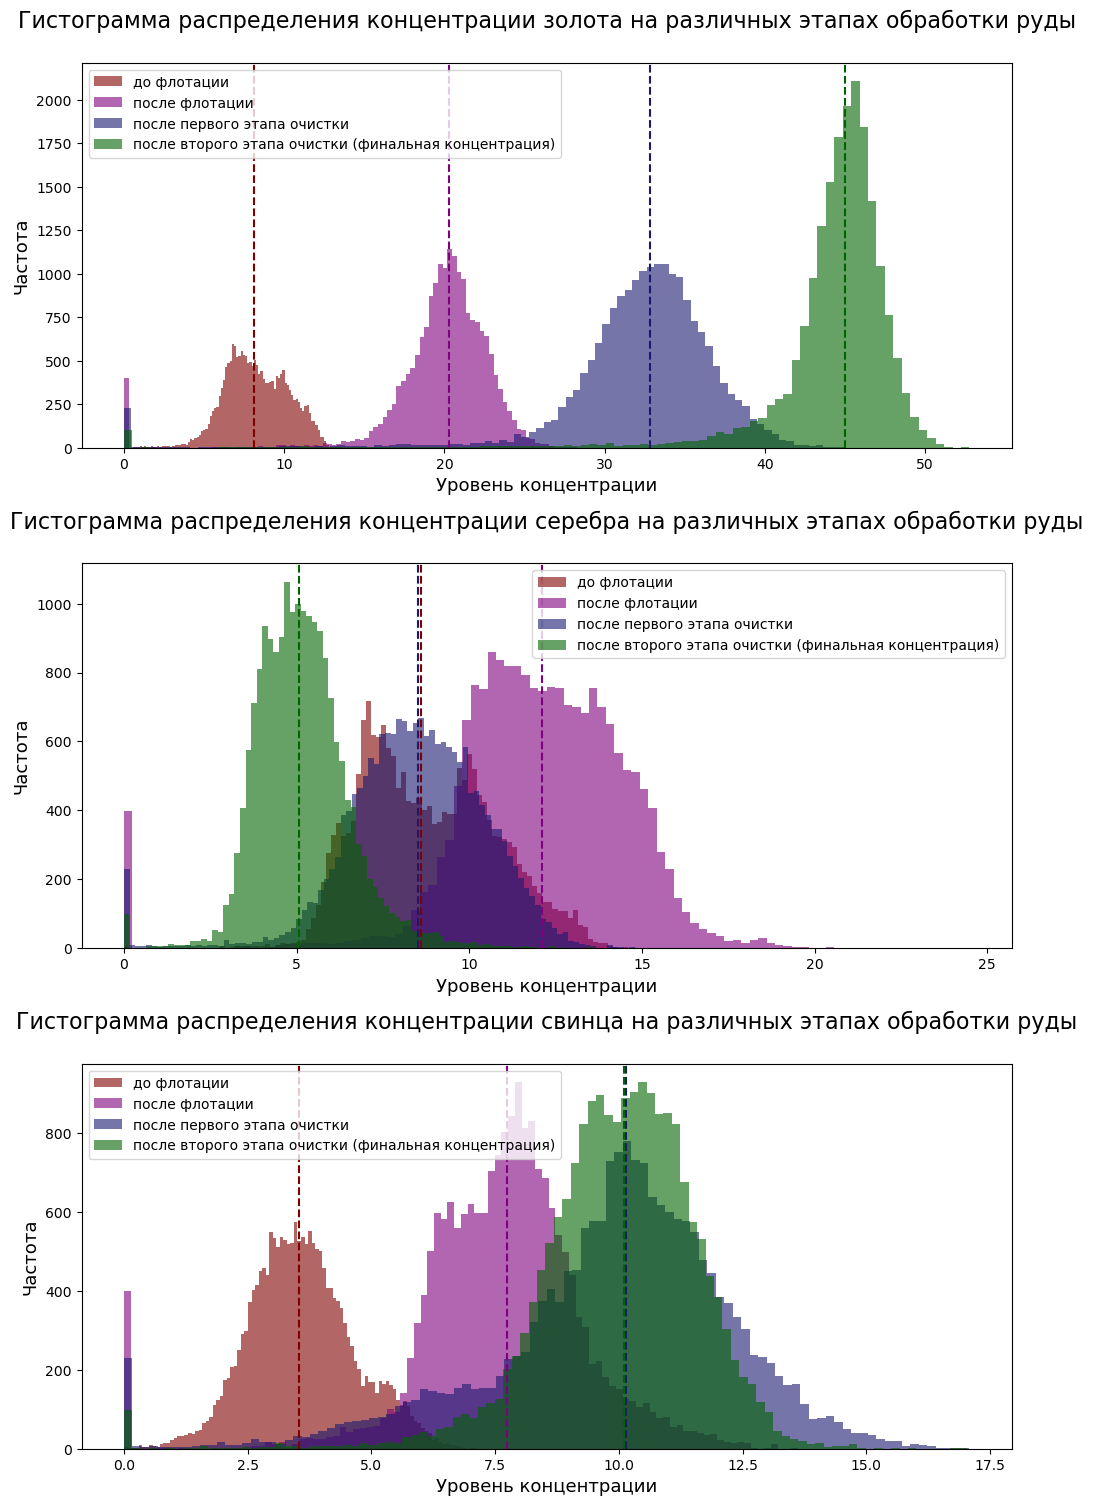

In [147]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

ax = [ax0, ax1, ax2]
metals = [('au', 'золота'), ('ag', 'серебра'), ('pb', 'свинца')]

for ax, metals in zip(ax, metals):
    
    ax.set_title(f'Гистограмма распределения концентрации {metals[1]} на различных этапах обработки руды\n', fontsize=16)
    ax.set_ylabel('Частота', fontsize=13)
    ax.set_xlabel('Уровень концентрации', fontsize=13)
    plt.subplots_adjust(hspace=0.3)

    ax.hist(
        full[f'rougher.input.feed_{metals[0]}'],
        label='до флотации',
        bins=100,
        alpha=0.6,
        color='#800000'
    );
    ax.axvline(full[f'rougher.input.feed_{metals[0]}'].median(), color='#800000', linestyle='dashed')
    
    ax.hist(
        full[f'rougher.output.concentrate_{metals[0]}'],
        label='после флотации',
        bins=100,
        alpha=0.6,
        color='#800080'
    );
    ax.axvline(full[f'rougher.output.concentrate_{metals[0]}'].median(), color='#800080', linestyle='dashed')
        
    ax.hist(
        full[f'primary_cleaner.output.concentrate_{metals[0]}'],
        label='после первого этапа очистки',
        bins=100,
        alpha=0.6,
        color='#191970'
    );
    ax.axvline(full[f'primary_cleaner.output.concentrate_{metals[0]}'].median(), color='#191970', linestyle='dashed')
    
    ax.hist(
        full[f'final.output.concentrate_{metals[0]}'],
        label='после второго этапа очистки (финальная концентрация)',
        bins=100,
        alpha=0.6,
        color='#006400'
    );
    ax.axvline(full[f'final.output.concentrate_{metals[0]}'].median(), color='#006400', linestyle='dashed')
    
    ax.legend()

**Выводы.**
- Концентрация золота в продукте увеличивалась примерно на 12-16 ед. изм. после каждого этапа обработки руды. На финальном этапе медианная концентрация золота составляла около 45 ед. изм.
- Концентрация серебра в продукте изменяется неравномерно: после флотации концентрация серебра увеличилась, а затем после первого этапа очистки уменьшилась примерно до того же уровня, что был до флотации; после второго этапа очистки концентрация серебра ещё раз уменьшилась и её медианное значение составила около 5 ед. изм.
- Концентрация свинца последовательно увеличивалась после флотации и первого этапа очистки, а после второго - осталась примерно на том же уровне.
- На всех графиках есть довольно много значений около нуля, которые сильно выбиваются из общей картины распределения концентрации металлов. Такое количество около нулевых значений похоже на аномалию - исправим это: заменим аномальные значения значениями NaN, а потом заполним пропуски с помощью линейной интерполяции. Однако так будем поступать не со всеми около нулевыми значениями, а только с теми, которые отличаются от предыдущих или следующих значений в столбце более, чем на 3 единицы измерения, поскольку в противном случае это может быть не аномальное значение, а просто около нулевое значение, попадающее в "хвост" распределения. Из параметров, характеризующих концентрацию металлов, в датафреймах `train` и `test` присутствуют только `rougher.input.feed_ag`, `rougher.input.feed_au` и `rougher.input.feed_pb`, однако, по гистограммам выше видно, что в этих столбцах (графики "до флотации") нет большого количества около нулевых значений, а значит устранить аномалии необходимо только в датафрейме `full` во всех столбцах с концентрацией металлов, кроме `rougher.input.feed_ag`, `rougher.input.feed_au` и `rougher.input.feed_pb` соответственно.

In [148]:
# На всякий случай сбросим индексы в датафрейме, чтобы избежать ошибок при замене аномалий на NaN
full = full.reset_index(drop=True)

columns = ['final.output.concentrate_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 
           'final.output.concentrate_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 
           'final.output.concentrate_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb']


for col in columns:
    for i in range(len(full)):
        if full.loc[i, col] < 1:
            if i == 0 and abs(full.loc[i, col] - full.loc[i+1, col]) > 3:
                full.loc[i, col] = np.nan

            if i == (len(full)-1) and abs(full.loc[i, col] - full.loc[i-1, col]) > 3:
                full.loc[i, col] = np.nan

            if abs(full.loc[i, col] - full.loc[i+1, col]) > 3 or abs(full.loc[i, col] - full.loc[i-1, col]) > 3:
                 full.loc[i, col] = np.nan

            # Если уже заполнили значением NaN предыдущую ячейку, то если значение в текущей ячейке меньше 1  
            # и в следующей - тоже меньше 1, то есть предположительно тоже аномальное значение,
            # то значение в текущей ячейке - аномалия. Пример: [6.22, 5.62, nan, 0.01, 0.02, 0.02, 3.39]
            if np.isnan(full.loc[i-1, col]) and full.loc[i+1, col] < 1:
                full.loc[i, col] = np.nan

            # Если значения концентрации в близайших ячейках меньше 1 и равны между собой, то это вероятно аномалии,
            # так как значения концентрации меняются со времене хотя бы на малую долю
            # Пример: [9.55, 1.53, 0.01, 0.01, 0.01, 4.81]
            if full.loc[i, col] == full.loc[i+1, col]:
                full.loc[i, col] = np.nan

In [149]:
fill_nan(full)

Чтобы убедиться, что аномалии устранены, можно повторно выполнить построение гистограмм распределения концентрации металлов на разных этапах обработки руды.

### 3.2. Анализ распределения размеров гранул сырья на обучающей и тестовой выборках

Сравним распределения размеров гранул сырья перед флотацией и перед очисткой на обучающей и тестовой выборках, поскольку если распределения сильно отличаются друг от друга, оценка модели будет неправильной. Размер тестовой и обучающей выборок сильно отличаются, поэтому для их визуального сравнения построим гистограмы плотностей; также выведем статистики каждого из распределений.

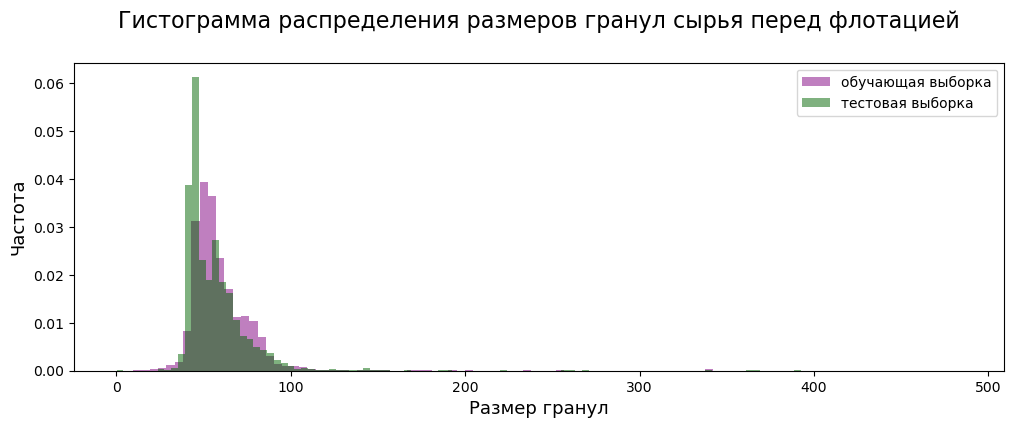

In [150]:
plt.figure(figsize=(12, 4))
plt.title('Гистограмма распределения размеров гранул сырья перед флотацией\n', fontsize=16)
plt.ylabel('Частота', fontsize=13)
plt.xlabel('Размер гранул', fontsize=13)
plt.hist(train['rougher.input.feed_size'], bins=100, alpha=0.5, density=True, color='#800080', label='обучающая выборка')
plt.hist(test['rougher.input.feed_size'], bins=100, alpha=0.5, density=True, color='#006400', label='тестовая выборка')
plt.legend();

In [151]:
(
    pd.concat([train['rougher.input.feed_size'].rename('train rougher.input.feed_size'), 
               test['rougher.input.feed_size'].rename('test rougher.input.feed_size')], axis=1)
    .describe()
)

,train rougher.input.feed_size,test rougher.input.feed_size
count,14149.000000,5290.000000
mean,60.097903,55.952835
std,23.023690,19.080372
min,9.659576,0.046369
25%,48.950593,43.906504
50%,55.269784,50.846843
75%,65.982466,62.451165
max,484.967466,392.494040


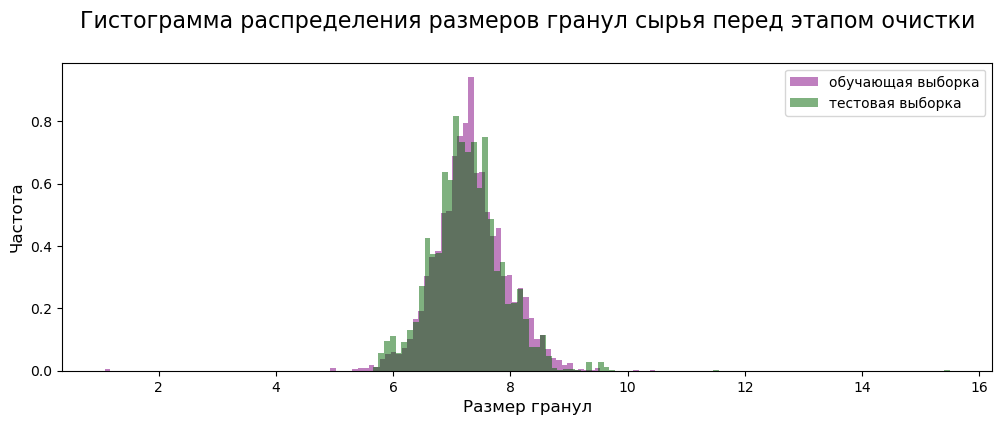

In [152]:
plt.figure(figsize=(12, 4))
plt.title('Гистограмма распределения размеров гранул сырья перед этапом очистки\n', fontsize=16)
plt.ylabel('Частота', fontsize=12)
plt.xlabel('Размер гранул', fontsize=12)
plt.hist(train['primary_cleaner.input.feed_size'], bins=100, alpha=0.5, density=True, 
         color='#800080', label='обучающая выборка');
plt.hist(test['primary_cleaner.input.feed_size'], bins=100, alpha=0.5, density=True, 
         color='#006400', label='тестовая выборка');
plt.legend();

In [153]:
(
    pd.concat([train['primary_cleaner.input.feed_size'].rename('train primary_cleaner.input.feed_size'), 
               test['primary_cleaner.input.feed_size'].rename('test primary_cleaner.input.feed_size')], axis=1)
    .describe()
)

,train primary_cleaner.input.feed_size,test primary_cleaner.input.feed_size
count,14149.000000,5290.000000
mean,7.322310,7.266339
std,0.614062,0.610219
min,1.080000,5.650000
25%,6.960000,6.890000
50%,7.290000,7.250000
75%,7.700000,7.600000
max,10.470000,15.500000


Общий вид распределений признаков `rougher.input.feed_size`, `primary_cleaner.input.feed_size` в тестовой и обучающей выборках очень похож между собой, за исключением небольших отличий, на которые могла повлиять разница в размерах выборок. 

По статистикам распределений признака `rougher.input.feed_size` можно заметить, что распределение признака в тестовой выборке немного смещено влево относительно обучающей, однако, на вид распределения это не влияет. Почти все статистики, кроме минимальных и максимальных значений, признака `primary_cleaner.input.feed_size` в выборках примерно равны; а максимальные и минимальные значения, судя по гистограмме, можно отнести к выбросам, на вид распределения они также не влияют. 

Таким образом, будем считать, что распределения размеров гранул сырья на обучающей и тестовой выборках не сильно отличаются друг от друга, а значит это не помешает предсказаниям модели.

### 3.3. Исследование суммарной концентрации всех веществ на разных этапах обработки руды

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

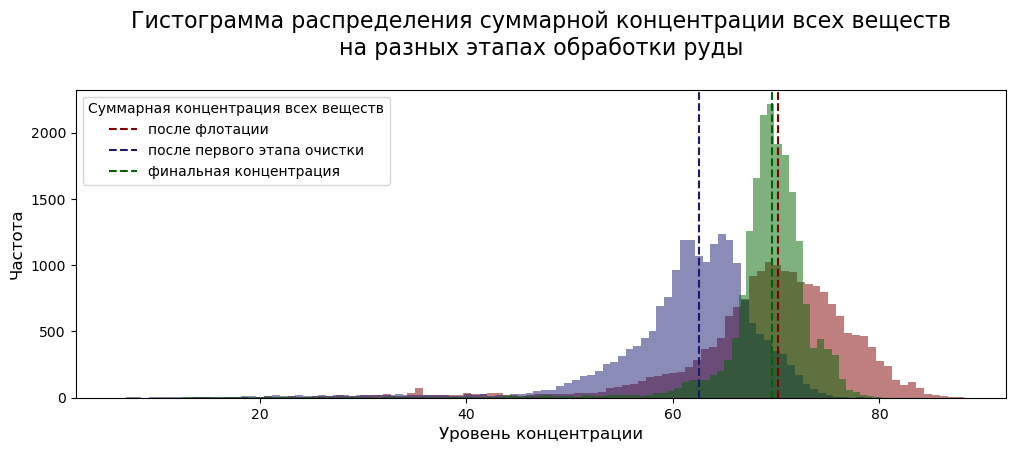

In [154]:
plt.figure(figsize=(12, 4))
plt.title('Гистограмма распределения суммарной концентрации всех веществ\nна разных этапах обработки руды\n', fontsize=16)    
plt.ylabel('Частота', fontsize=12)
plt.xlabel('Уровень концентрации', fontsize=12)

for stage, color in zip(['rougher.output.', 'primary_cleaner.output.', 'final.output.'], ['#800000', '#191970', '#006400']):
    sum_concentrate = full[f'{stage}concentrate_au'] + full[f'{stage}concentrate_ag'] + \
        full[f'{stage}concentrate_pb'] + full[f'{stage}concentrate_sol']
    
    plt.axvline(sum_concentrate.median(), color=color, linestyle='dashed')
    plt.hist(sum_concentrate, bins=100, alpha=0.5, color=color)
        
plt.legend(['после флотации', 'после первого этапа очистки', 'финальная концентрация'], 
           title='Cуммарная концентрация всех веществ'); 

Вспомним, что этапы обработки руды идут в следующем порядке: флотация, затем первый и второй этапы очистки, - соответственно на выходе второго этапа получают финальный концентрат.

Таким образом, получаем, что после первого этапа очистки суммарная концентрация веществ в продукте уменьшается по сравнению с концентрацией, получаемой после этапа флотации, а после второго этапа очистки - увеличивается (финальный концентрат). Причём медианная концентрация веществ после флотации и в окончательном продукте примерно одинаковая, однако, в окончательном продукте выше вероятность получения более высокого значения концентрации, поскольку гистограмма более сжатая и высокая.

## 4. Построение и выбор модели машинного обучения

### 4.1. Подготовка перед обучением моделей

Напишем функцию для вычисления метрики качества sMAPE. Значения этой метрики лежат в диапазоне от 0% до 200%. Причём sMAPE - это мера точности, поэтому чем ниже её значение, тем лучше.

In [155]:
def smape(true, pred):
     return (2 * abs(true - pred) / (abs(true) + abs(pred))).mean() * 100 

Создадим свой оценщик на основе функции `smape`, который будем использовать для поиска модели с лучшими показателями качества.

In [156]:
smape_error = make_scorer(smape, greater_is_better=False)

Разделим данные на признаки и целевые признаки.

In [157]:
features_train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_rougher = train['rougher.output.recovery']
target_train_final = train['final.output.recovery']

features_test = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_rougher = test['rougher.output.recovery']
target_test_final = test['final.output.recovery']

### 4.2. Обучение моделей и выбор лучшей из них

По задаче нужно предсказать 2 целевых признака `rougher.output.recovery` и `final.output.recovery`, и для каждого из них мы будем выбирать модель независимо от другого целевого признака, поскольку модель с лучшей метрикой качества для одного целевого признака может быть далеко не самой точной для другого.

Чтобы адекватно оценивать значение метрики качества моделей sMAPE, обучим константную модель, которая всегда будет предсказывать медианное значение выборки во всех случаях, и для каждого целевого признака найдём значение sMAPE с помощью этой модели. Соответственно, если в дальнейшем обученная модель будет демонстрировать значение метрики качества большее (т. к. sMAPE нужно минимизировать) чем то, которое показала константная модель, то такую модель нельзя считать адекватной и использовать для достижения поставленной цели.

In [158]:
model = DummyRegressor(strategy='median')
model.fit(features_train, target_train_rougher)
print('rougher.output.recovery: максимальное sMAPE = ', 
      round(-cross_val_score(model, features_train, target_train_rougher, cv=5, scoring=smape_error).mean(), 4)
     )

model.fit(features_train, target_train_final)
print('final.output.recovery: максимальное sMAPE = ', 
      round(-cross_val_score(model, features_train, target_train_final, cv=5, scoring=smape_error).mean(), 4)
     )

rougher.output.recovery: максимальное sMAPE =  11.8867
final.output.recovery: максимальное sMAPE =  11.3437


Теперь обучим модели линейной регрессии, решающего дерева, случайного леса и градиентного бустинга для регрессии и оценим их качество кросс-валидацией. 

In [28]:
%%time
# МОДЕЛЬ ЛИНЕЙНОЙ РЕГРЕССИИ
# Обучим модель линейной регрессии на масштабированных данных

scaler = MinMaxScaler()
scaler.fit(features_train)
scaler_features_train = scaler.transform(features_train)

model = LinearRegression()

model.fit(scaler_features_train, target_train_rougher)
print('rougher.output.recovery: sMAPE = ', 
      round(-cross_val_score(model, scaler_features_train, target_train_rougher, cv=5, scoring=smape_error).mean(), 4)
     )

model.fit(scaler_features_train, target_train_final)
print('final.output.recovery: sMAPE = ', 
      round(-cross_val_score(model, scaler_features_train, target_train_final, cv=5, scoring=smape_error).mean(), 4)
     )

rougher.output.recovery: sMAPE =  12.7671
final.output.recovery: sMAPE =  12.2688


In [29]:
%%time
# МОДЕЛЬ РЕШАЮЩЕГО ДЕРЕВА

model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE) 
parametrs = {
    'max_depth': range(2, 31),
    'min_samples_split': range(2, 6),
    'min_samples_leaf': range(1, 6)
}

grid = RandomizedSearchCV(model_tree, parametrs, cv=5, n_iter=200, scoring=smape_error, n_jobs=-1, 
                          random_state=RANDOM_STATE, verbose=3)

grid.fit(features_train, target_train_rougher)
print(f'rougher.output.recovery: sMAPE = {round(-grid.best_score_, 4)}',
      f'\nИ соответствующие параметры модели: {grid.best_params_}'
     )

grid.fit(features_train, target_train_final)
print(f'final.output.recovery: sMAPE = {round(-grid.best_score_, 4)}',
      f'\nИ соответствующие параметры модели: {grid.best_params_}'
     )

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
rougher.output.recovery: sMAPE = 11.2827 
И соответствующие параметры модели: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
final.output.recovery: sMAPE = 10.82 
И соответствующие параметры модели: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 2}
Wall time: 2min 41s


In [30]:
%%time
# МОДЕЛЬ СЛУЧАЙНОГО ЛЕСА

model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
parametrs = {
    'n_estimators': range(60, 501, 30),
    'max_depth': range(5, 31, 3),
    'min_samples_leaf': range(1, 5)
}

grid = RandomizedSearchCV(model, parametrs, cv=5, n_iter=20, scoring=smape_error, n_jobs=-1, 
                          random_state=RANDOM_STATE, verbose=3)

grid.fit(features_train, target_train_rougher)
print(f'rougher.output.recovery: sMAPE = {round(-grid.best_score_, 4)}',
      f'\nИ соответствующие параметры модели: {grid.best_params_}'
     )

grid.fit(features_train, target_train_final)
print(f'final.output.recovery: sMAPE = {round(-grid.best_score_, 4)}',
      f'\nИ соответствующие параметры модели: {grid.best_params_}'
     )

Fitting 5 folds for each of 20 candidates, totalling 100 fits
rougher.output.recovery: sMAPE = 11.0251 
И соответствующие параметры модели: {'n_estimators': 60, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
final.output.recovery: sMAPE = 10.1968 
И соответствующие параметры модели: {'n_estimators': 60, 'min_samples_leaf': 4, 'max_depth': 5}
Wall time: 1h 31min 45s


In [31]:
%%time
# МОДЕЛЬ ГРАДИЕНТНОГО БУСТИНГА

model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
parametrs = {
    'learning_rate': np.arange(0.01, 1, 0.2),
    'depth': range(2, 11),
    'n_estimators': range(20, 301, 20),
}

grid = RandomizedSearchCV(model, parametrs, cv=5, n_iter=30, scoring=smape_error, n_jobs=-1, 
                          random_state=RANDOM_STATE, verbose=3)

grid.fit(features_train, target_train_rougher)
print(f'rougher.output.recovery: sMAPE = {round(-grid.best_score_, 4)}',
      f'\nИ соответствующие параметры модели: {grid.best_params_}'
     )

grid.fit(features_train, target_train_final)
print(f'final.output.recovery: sMAPE = {round(-grid.best_score_, 4)}',
      f'\nИ соответствующие параметры модели: {grid.best_params_}'
     )

Fitting 5 folds for each of 30 candidates, totalling 150 fits
rougher.output.recovery: sMAPE = 10.7149 
И соответствующие параметры модели: {'n_estimators': 240, 'learning_rate': 0.01, 'depth': 9}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
final.output.recovery: sMAPE = 9.7117 
И соответствующие параметры модели: {'n_estimators': 240, 'learning_rate': 0.01, 'depth': 9}
Wall time: 15min 1s


Все модели, кроме модели линейной регрессии, прошли проверку на адекватность: полученные с их помощью значения метрики sMAPE для целевых признаков меньше соответствующих значений, полученных с помощью константной модели.

Наилучшие значения метрики качества sMAPE, то есть наибольшую точность предсказаний, показала модель градиентного бустинга `CatBoostRegressor` с гиперпараметрами `n_estimators=240`, `depth=9`, `learning_rate=0.01`. 

### 4.3. Тестирование модели

Протестируем модель `CatBoostRegressor`, выбранную как модель с лучшими метриками качества для двух целевых признаков.

In [32]:
best_model = CatBoostRegressor(**grid.best_params_, random_state=RANDOM_STATE, verbose=False)

best_model.fit(features_test, target_test_rougher)
best_smape_rougher = -cross_val_score(best_model, features_test, target_test_rougher, cv=5, scoring=smape_error).mean()
print('rougher.output.recovery: лучшее sMAPE = ', round(best_smape_rougher, 4))

best_model.fit(features_test, target_test_final)
best_smape_final = -cross_val_score(best_model, features_test, target_test_final, cv=5, scoring=smape_error).mean()
print('final.output.recovery: лучшее sMAPE = ', round(best_smape_final, 4))

print('Итоговое значение sMAPE =', round(0.25 * best_smape_rougher + 0.75 * best_smape_final, 4))

rougher.output.recovery: лучшее sMAPE =  8.4272
final.output.recovery: лучшее sMAPE =  8.8854
Итоговое значение sMAPE = 8.7709


Видим, что значение метрики качества, полученное при тестировании модели, даже немного лучше, чем при её валидации.

В результате получили, что модель градиентного бустинга с гиперпараметрами `n_estimators=240`, `depth=9` и `learning_rate=0.01` наиболее точно предсказывает значения целевого признака, поэтому лучше остальных подходит для достижения поставленной цели.

## 5. Выводы

При выполнении проекта я выделила следующие ключевые шаги.
1. Удаление из обучающей выборки признаков, которых нет в тестовой, и добавить в эти выборки целевые признаки, содержащиеся в исходных данных.
2. Выбор правильного метода заполнения пропусков в данных.
3. Подготовка признаков перед обучением моделей: масштабирование численных признаков.
3. Обучение моделей и выбор лучшей.
4. Тестирование выбранной модели.

Для обучения моделей использовались все признаки, содержащиеся в тестовой выборке, кроме признака `date`, а это 52 признака.

Была выполнена следующая предобработка признаков.
* Заполнение пропусков. Мы заполняли пропуски с помощью метода линейной интерполяции; это подходящий метод в нашем случае, поскольку в датафреймах строки расположены последовательно с учётом даты и времени получения информации, соответственно значения в соседних ячейках зависят друг от друга, поскольку параметры руды изменяются не случайным образом, а последовательно и постепенно.
* Масштабирование численных признаков с помощью `MinMaxScaler` из библиотеки `sklearn`. Масштабированные признаки использовались только для обучения модели линейной регрессии, поскольку масштаб признаков наиболее важен именно для линейных моделей, подбирающих коэффициенты для этих признаков.

Лучший результат на этапе кросс-валидации показала модель градиентного бустинга `CatBoostRegressor` с гиперпараметрами `n_estimators=240`, `learning_rate=0.01`, `depth=9`, `random_state=0`. Итоговое значение sMAPE этой модели тестовой выборке равно 8.7709.